### Import Library

In [156]:
import pandas as pd
import seaborn as sns
import os
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import warnings
from scipy.spatial import ConvexHull
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from adjustText import adjust_text
from mpl_toolkits.axes_grid1 import make_axes_locatable


### Define the functions

In [157]:
# Function to create a dissimilarity matrix from the data
def create_dissimilarity_matrix(data, everydaysound_names, catsound_names):
    stimuli = everydaysound_names + catsound_names #TBFixed
    matrix = np.full((len(stimuli), len(stimuli)), np.nan)  # Initialize with NaN values
    np.fill_diagonal(matrix, 0)
    for _, row in data.iterrows():
        i = stimuli.index(row['Spreadsheet: A'].replace('.wav', ''))
        j = stimuli.index(row['Spreadsheet: B'].replace('.wav', ''))
        matrix[i, j] = matrix[j, i] = row['Response']
    
    # Check for NaN values and fill them symmetrically
    if np.isnan(matrix).any():
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                if np.isnan(matrix[i, j]):
                    random_value = np.random.randint(0, 7)
                    matrix[i, j] = matrix[j, i] = random_value
        warnings.warn("Input X contains NaN and has been filled symmetrically with random values.")
    
    return matrix

def plot_individual_MDS(coordinates_dict, stimuli, everydaysound_names, output_csv_path):
    n_subjects = len(coordinates_dict)
    fig, ax = plt.subplots(nrows=n_subjects, ncols=1, figsize=(8, n_subjects * 5))
    axes = ax if n_subjects > 1 else [ax]  # Ensure axes is always a list
    for ax, (participant, coords) in zip(axes, coordinates_dict.items()):
        for i, stimulus in enumerate(stimuli):
            category = "complex_tone" if stimulus in everydaysound_names else "everydaysound"
            color = 'green' if category == "complex_tone" else 'blue'
            ax.scatter(coords[i, 0], coords[i, 1], color=color, alpha=0.6)
            ax.annotate(stimulus.replace('.wav', ''), (coords[i, 0], coords[i, 1]))
        
        x_min, x_max = -6, 6  # example values, adjust as necessary
        y_min, y_max = -6, 6  # example values, adjust as necessary
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_title(f"Participant {participant}")
        #ax.axis('equal')

    plt.tight_layout()
    
    # Save the individual MDS plot
    plot_individual_path = os.path.join(os.path.dirname(output_csv_path), "individual_mds_plot.png")
    plt.savefig(plot_individual_path)
    plt.show()


def plot_average_MDS_with_hulls(average_coordinates, stimuli, everydaysound_names, catsound_names, output_csv_path):
    # Rename everyday sounds by removing '_3ms' and handle specific replacements
    new_everydaysound_names = [sound.replace('_3ms', '') for sound in everydaysound_names]
    new_everydaysound_names = [sound.replace('car_engine', 'car') for sound in new_everydaysound_names]
    new_everydaysound_names = [sound.replace('sizzling_pan', 'sizzling') for sound in new_everydaysound_names]
    # Rename cat sounds
    new_catsound_names =  ["Cat1"] + ["Cat" + str(i+2) for i in range(1, 9)]

    everydaysound_rename = dict(zip(everydaysound_names, new_everydaysound_names))
    catsound_rename = dict(zip(catsound_names, new_catsound_names))

    plt.figure(figsize=(10, 10))

    texts = []
    for i, stimulus in enumerate(stimuli):
        category = "everydaysound" if stimulus in everydaysound_names else "catsound"
        color = 'green' if category == "everydaysound" else 'blue'
        marker = 'o'
        plt.scatter(average_coordinates[i, 0], average_coordinates[i, 1], color=color, marker=marker, alpha=1, s=100)

        # Check rename
        new_name = stimulus
        if category == "everydaysound" and stimulus in everydaysound_rename:
            new_name = everydaysound_rename[stimulus]
        elif category == "catsound" and stimulus in catsound_rename:
            new_name = catsound_rename[stimulus]

        text = plt.annotate(new_name, (average_coordinates[i, 0], average_coordinates[i, 1]), fontsize=20)
        texts.append(text)

    # Create convex hulls
    for category, color in [("everydaysound", "green"), ("catsound", "blue")]:
        relevant_stimuli = everydaysound_names if category == "everydaysound" else catsound_names
        relevant_indices = [stimuli.index(stim) for stim in relevant_stimuli if stim in stimuli]
        
        relevant_coords = average_coordinates[relevant_indices]
        hull = ConvexHull(relevant_coords)
        for simplex in hull.simplices:
            plt.plot(relevant_coords[simplex, 0], relevant_coords[simplex, 1], color, alpha=0.7)
    
    x_min, x_max = -6, 6
    y_min, y_max = -6, 6

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.grid(True)
    # For x-axis
    plt.tick_params(axis='x', labelsize=22)  # '14' is the desired font size
    # For y-axis
    plt.tick_params(axis='y', labelsize=22)  # '14' is the desired font size

    # Create a custom legend
    legend_elements = [Line2D([0], [0], color='green', marker='o', label='Everyday Sound', markersize=10, alpha=1),
                       Line2D([0], [0], color='blue', marker='o', label='Cat Meow', markersize=10, alpha=1)]
    plt.legend(handles=legend_elements, loc='upper left', fontsize=22)

    #plt.title("Average MDS Plot with Category Hulls", fontsize=18)
    plt.xlabel("MDS Dimension 1", fontsize=26)
    plt.ylabel("MDS Dimension 2", fontsize=26)

    adjust_text(texts)

    plot_path = os.path.join(os.path.dirname(output_csv_path), "average_mds_plot_with_hulls.png")
    plt.savefig(plot_path)
    plt.show()



### MDS plots

In [158]:
# Step 1: Define the WAV file names
everydaysound_names =  ['baby_3ms', 'bell_3ms', 'frog_3ms', 'car_engine_3ms', 'cough_3ms', 'snore_3ms', 'sheep_3ms', 'sizzling_pan_3ms', 'laugh_3ms']
catsound_names = ['1_300ms','5_300ms','8_300ms','11_300ms','17_300ms','18_300ms','24_300ms','25_300ms','26_300ms']

# Step 2: Process the input CSV file
input_csv_path = '/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/perceptual-similarity-everydaySound_catSound/data/prolific-8-29/data_exp_141798-v3/data_exp_141798-v3_task-lwvw.csv'  # Replace with your input CSV file path
output_csv_path = '/Volumes/T7/CMU LiMN Research/Perceptual Organization/Result & Analysis/perceptual-similarity-everydaySound_catSound/result/prolific-8-29-result/processed_ratings.csv'  # Name of the output CSV file

# Read the CSV file using pandas
data = pd.read_csv(input_csv_path)

# Filter the data
filtegreen_data = data[data['Component Name'] == 'Rating Scale'][['Component Name', 'Participant Private ID', 'Spreadsheet: A', 'Spreadsheet: B','Response']]

# Save the filtegreen data to a new CSV file
filtegreen_data.to_csv(output_csv_path, index=False)

# Read the Processed CSV
data = pd.read_csv(output_csv_path)

/var/folders/y9/0k_9rd192c3cw4x9z34p1_zr0000gn/T/ipykernel_41050/4275509318.py:10: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(input_csv_path)


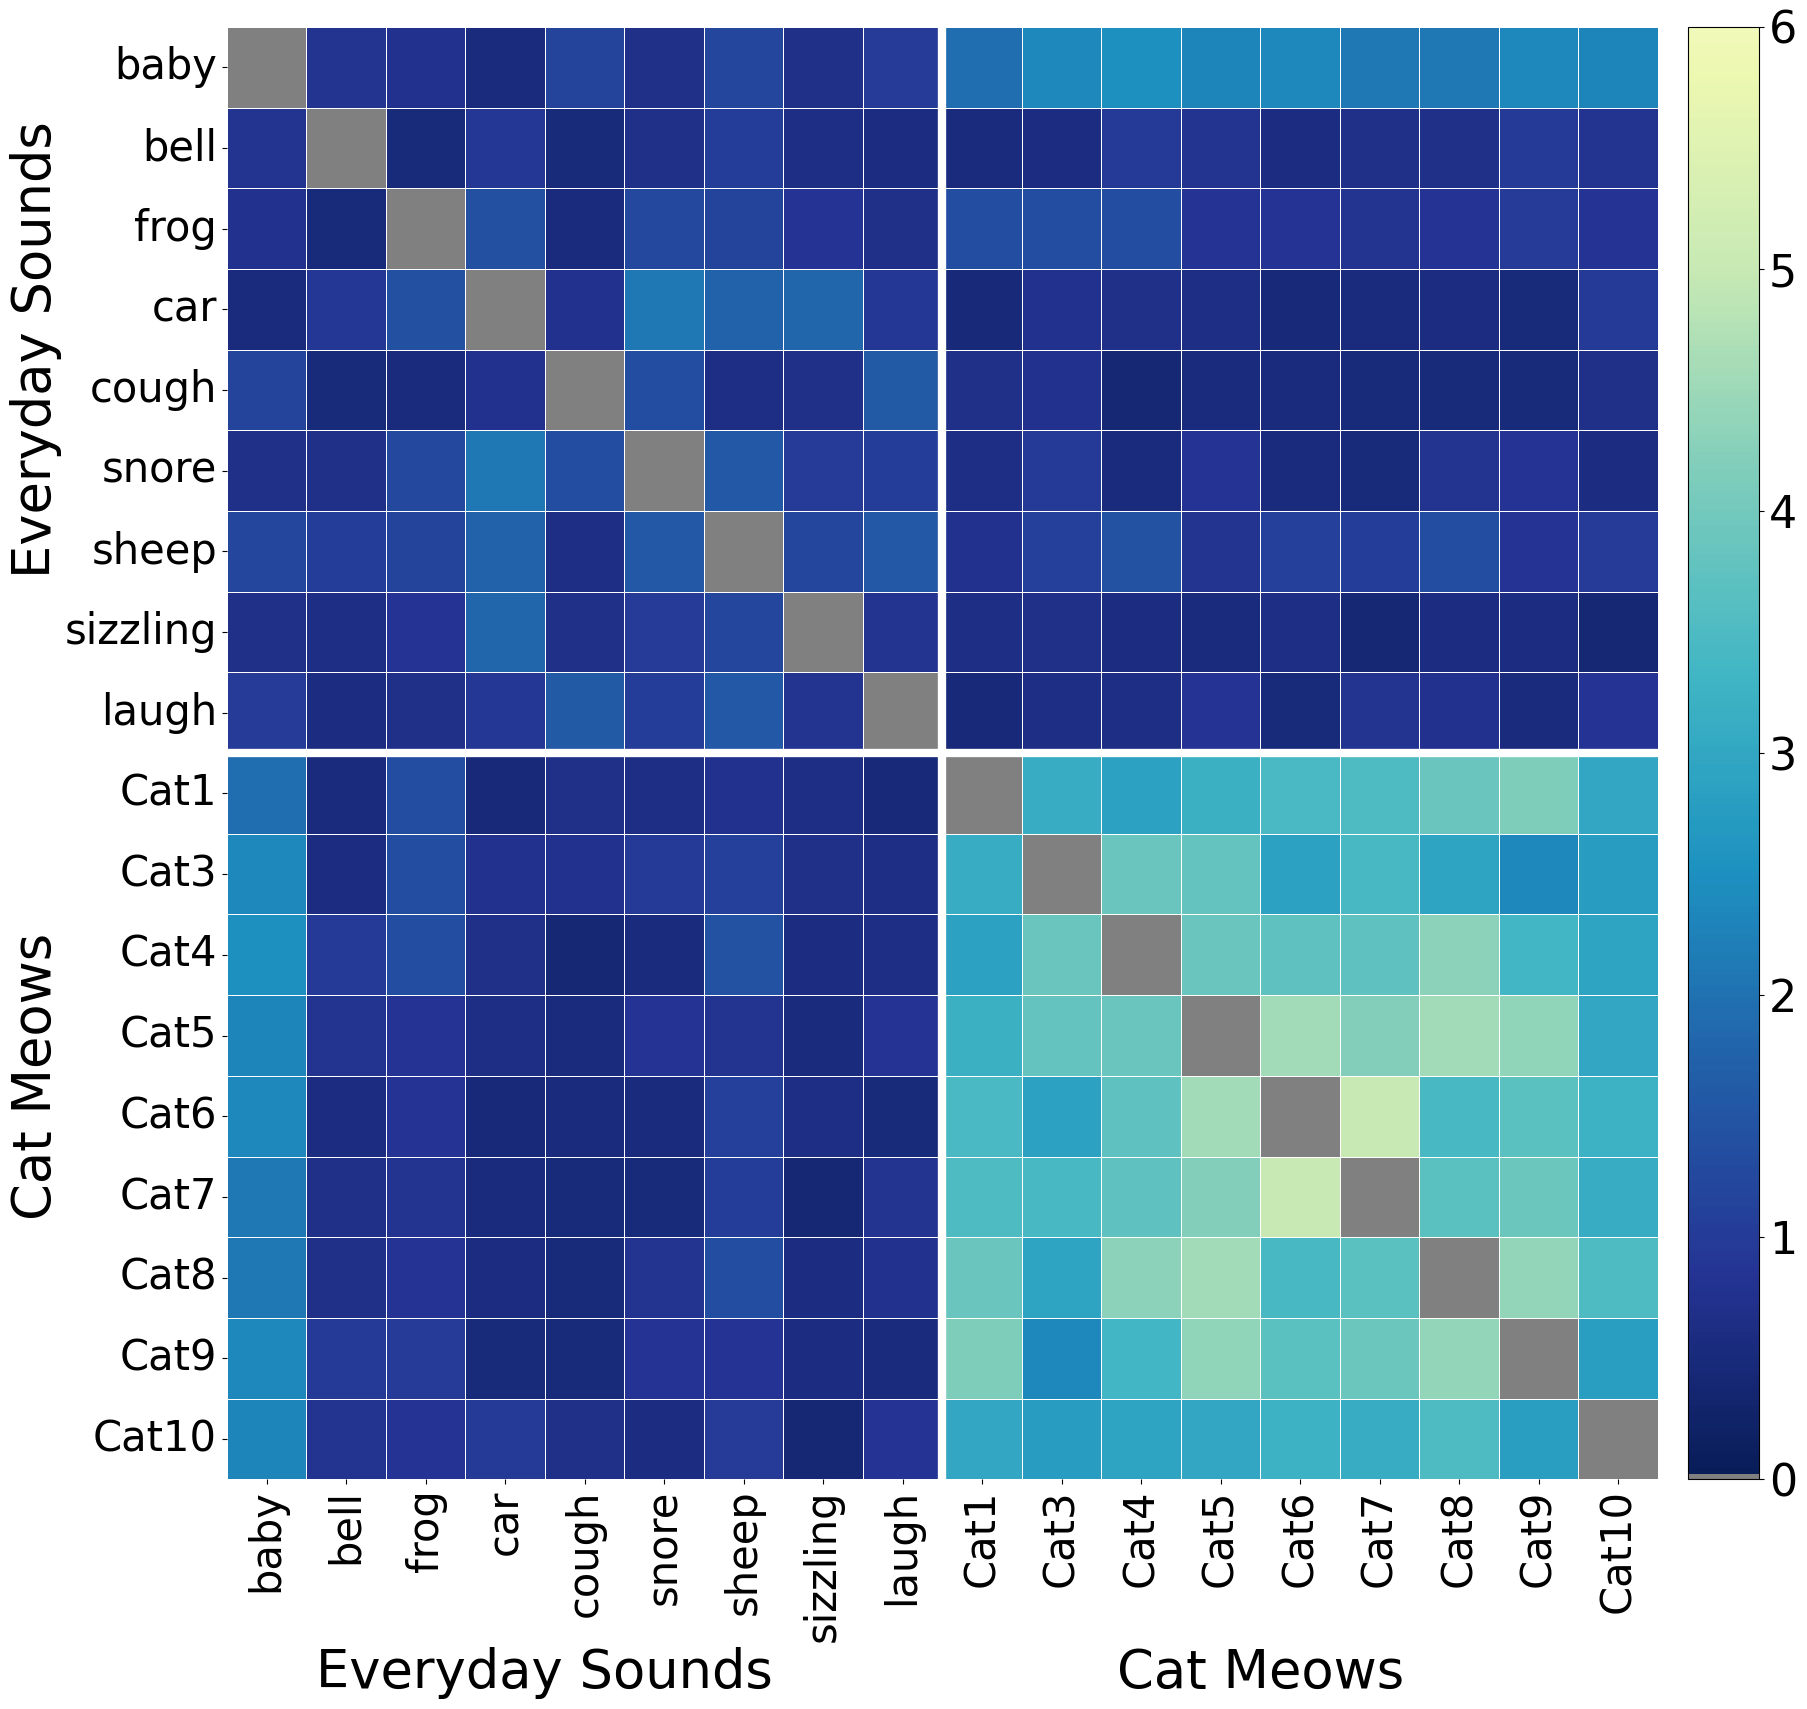

In [159]:
# Create a dissimilarity matrix for each participant and an average matrix
participants = data['Participant Private ID'].unique()
individual_matrices = {participant: create_dissimilarity_matrix(data[data['Participant Private ID'] == participant], everydaysound_names, catsound_names) 
                       for participant in participants}
average_matrix = np.mean(np.array([matrix for matrix in individual_matrices.values()]), axis=0)

# Rename everyday sounds by removing '_3ms' and handle specific replacements
new_everydaysound_names = [sound.replace('_3ms', '') for sound in everydaysound_names]
new_everydaysound_names = [sound.replace('car_engine', 'car') for sound in new_everydaysound_names]
new_everydaysound_names = [sound.replace('sizzling_pan', 'sizzling') for sound in new_everydaysound_names]

# Rename cat sounds by removing '_300ms' and label them 'Cat 1', 'Cat 2', ...
new_catsound_names =  ["Cat1"] + ["Cat" + str(i+2) for i in range(1, 9)]

combined_names = new_everydaysound_names + new_catsound_names

# Step 1: Modify the matrix
special_value = -1  # Choose a value that's not in your existing matrix data range
np.fill_diagonal(average_matrix, special_value)

# Step 2: Create a custom colormap
colors_heatmap = plt.cm.YlGnBu(np.linspace(0.1, 1, 256))
colors_heatmap[0] = [0.5, 0.5, 0.5, 1]  # RGB for gray with full opacity
custom_colormap_heatmap = mcolors.LinearSegmentedColormap.from_list('custom_heatmap', colors_heatmap)

# Create a custom colormap for the colorbar
colors_cbar = plt.cm.YlGnBu(np.linspace(1, 0.1, 256))
colors_cbar[0] = [0.5, 0.5, 0.5, 1]  # RGB for gray with full opacity
custom_colormap_cbar = mcolors.LinearSegmentedColormap.from_list('custom_cbar', colors_cbar)

# Plot the dissimilarity matrix heatmap
plt.figure(figsize=(18, 17))
ax = sns.heatmap(average_matrix, cmap=custom_colormap_heatmap, annot=False, 
                 xticklabels=combined_names, yticklabels=combined_names, 
                 linewidths=0.5, cbar=False, vmin=0, vmax=6)

# Using make_axes_locatable to create space for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.3)

# Manually create a new colorbar with the flipped colormap
#cbar_ax = ax.figure.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=6), cmap=custom_colormap_cbar), 
                    cax=cax)

# Adjust the colorbar's font size and set the scale from 6 at the top to 0 at the bottom
cbar.ax.tick_params(labelsize=32)
cbar.set_ticks([0, 1, 2, 3, 4, 5, 6])
cbar.set_ticklabels(['0', '1', '2', '3', '4', '5', '6']) 


# Configure plot aesthetics
ax.xaxis.tick_bottom()
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=30)
ax.axvline(9, color='white', linewidth=6)
ax.axhline(9, color='white', linewidth=6)

# Increase the fontsize for custom text
fontsize_label = 38
ax.text(4, 20.4, "Everyday Sounds", ha="center", va="center", color="black", fontsize=fontsize_label)
ax.text(13, 20.4, "Cat Meows", ha="center", va="center", color="black", fontsize=fontsize_label)
ax.text(-2.4, 4, "Everyday Sounds", ha="center", va="center", color="black", rotation=90, fontsize=fontsize_label)
ax.text(-2.4, 13, "Cat Meows", ha="center", va="center", color="black", rotation=90, fontsize=fontsize_label)

#plt.title("Dissimilarity Matrix", fontsize=36)
plt.tight_layout()
plot_individual_path = os.path.join(os.path.dirname(output_csv_path), "individual_RDM_plot.png")
plt.savefig(plot_individual_path)
plt.show()


Stress Ratio: 0.03346928046952597


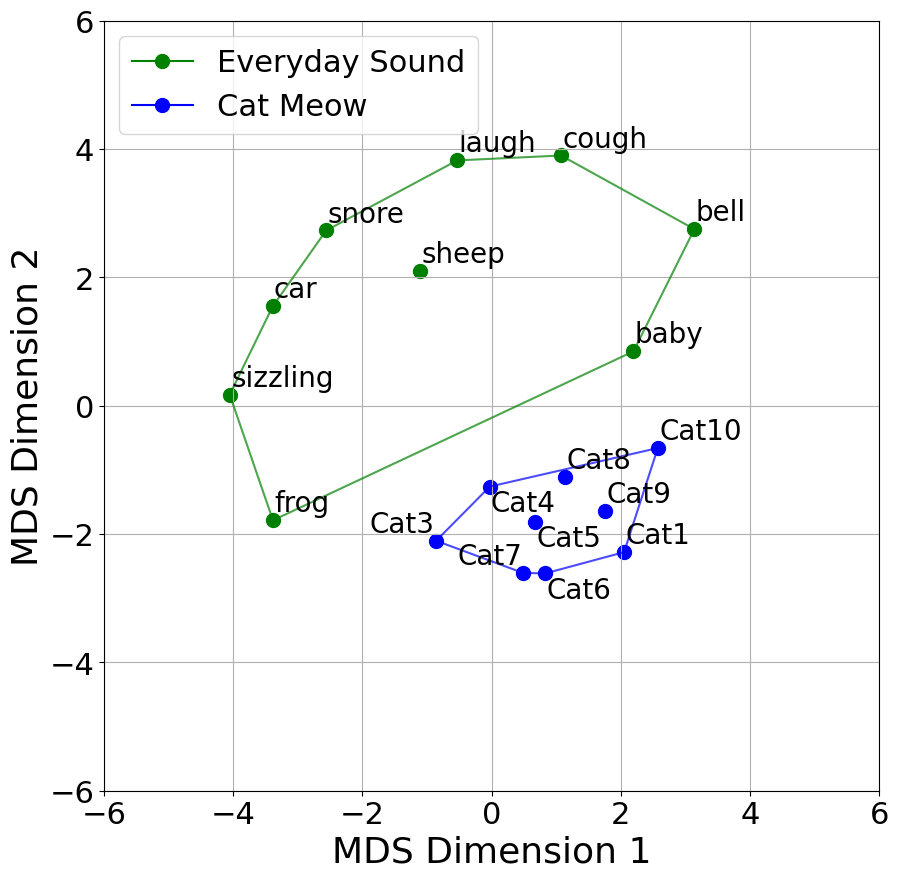

In [160]:
# MDS Analysis
mds = MDS(dissimilarity='precomputed', random_state=42, normalized_stress=False)
individual_coordinates = {participant: mds.fit_transform(matrix) for participant, matrix in individual_matrices.items()}
average_coordinates = mds.fit_transform(average_matrix)

# Access the stress value
stress_value = mds.stress_
#print(f"Stress Value: {stress_value}")
input_disparities = mds.dissimilarity_matrix_  # the original distance matrix used in the MDS fit
stress_ratio = stress_value / np.sum(input_disparities**2)
print(f"Stress Ratio: {stress_ratio}")

# #~~~~~~~~~ Test ~~~~~~~~~~~~~~~
# # Check if matrices are the same
# single_participant_matrix = individual_matrices[list(individual_matrices.keys())[0]] # Extracting the matrix for the single participant
# is_same_matrix = np.array_equal(single_participant_matrix, average_matrix)
# print(f"Matrices are the same: {is_same_matrix}")

# # Check the MDS outputs
# single_participant_coordinates = individual_coordinates[list(individual_coordinates.keys())[0]] # Extracting the coordinates for the single participant

# # Calculate pairwise distances for both sets of coordinates and compare
# from scipy.spatial import distance_matrix
# dist_matrix_individual = distance_matrix(single_participant_coordinates, single_participant_coordinates)
# dist_matrix_average = distance_matrix(average_coordinates, average_coordinates)

# is_same_mds_output = np.allclose(dist_matrix_individual, dist_matrix_average)
# print(f"MDS outputs are the same: {is_same_mds_output}")

# # Find the indices where the matrices differ
# diff_indices = np.where(single_participant_matrix != average_matrix)

# # Print the differing indices and the corresponding values from both matrices
# for index in zip(diff_indices[0], diff_indices[1]): 
#     print(f"Index: {index}, Single Participant Value: {single_participant_matrix[index]}, Average Value: {average_matrix[index]}")

# ~~~~~~~~~~~~~~~ Plot individual and average MDS results ~~~~~~~~~~~~~~~~~~~~~~~~~~
#plot_individual_MDS(individual_coordinates, everydaysound_names + catsound_names, everydaysound_names, output_csv_path)
#plot_average_MDS(average_coordinates, everydaysound_names + catsound_names, everydaysound_names, output_csv_path)
plot_average_MDS_with_hulls(average_coordinates, everydaysound_names + catsound_names, everydaysound_names, catsound_names, output_csv_path)

### Interpreting the MDS Plot

#### Distance between Categories:
- The distance between the centroids (average position) of the two categories can provide insights into their perceived dissimilarity.
- A larger distance suggests that participants perceive the two categories as being more distinct or dissimilar from each other.

#### Overlap of Convex Hulls:
- If the convex hulls (or the "boundary") of the two categories overlap, it suggests that there's some perceived similarity between items in those categories.
- Lack of overlap indicates distinct perceptual categories.

#### Position of Individual Stimuli:
- Items located closer to the boundary of their category's convex hull might be perceived as more ambiguous or more similar to items from the other category.
- Items situated deep within their category's hull are likely perceived as prototypical or strongly representative of their category.

#### Understanding the Stress Ratio in MDS

- Multidimensional Scaling (MDS) is a technique used to visualize the structure of complex data in a lower-dimensional space, often two dimensions for easy visualization. One of the critical measures of how well this lower-dimensional representation captures the relationships in the original high-dimensional data is the Stress Ratio.

- The Stress Ratio quantifies the misfit between the distances in the original data and the distances in the MDS representation. 

- **Interpretation Guide**:
  - **Below 0.05**: Excellent representation.
  - **Between 0.05 and 0.1**: Good representation.
  - **Between 0.1 and 0.2**: Fair representation.
  - **Above 0.2**: Potentially poor representation.

In [161]:
from scipy.spatial.distance import euclidean
from scipy.stats import ttest_rel

# Combine the lists
all_stimuli = everydaysound_names + catsound_names

everyday_distances = []
cat_distances = []

for participant, coordinates in individual_coordinates.items():
    
    # Check if the length of the coordinates is as expected
    if len(coordinates) != len(all_stimuli):
        print(f"Unexpected number of coordinates for participant {participant}")
        continue

    # Get indices for each category
    everyday_indices = [all_stimuli.index(sound) for sound in everydaysound_names]
    cat_indices = [all_stimuli.index(cat) for cat in catsound_names]

    # Mean coordinates for each category
    everyday_mean = np.mean([coordinates[i] for i in everyday_indices], axis=0)
    cat_mean = np.mean([coordinates[i] for i in cat_indices], axis=0)
    
    # Mean distance of each stimulus to its category mean
    everyday_distance = np.mean([euclidean(coordinates[i], everyday_mean) for i in everyday_indices])
    cat_distance = np.mean([euclidean(coordinates[i], cat_mean) for i in cat_indices])
    
    everyday_distances.append(everyday_distance)
    cat_distances.append(cat_distance)

# Paired t-test
t_stat, p_value = ttest_rel(everyday_distances, cat_distances)

print(f"t-statistic: {t_stat:.3f}, p-value: {p_value:.5f}")


t-statistic: 8.505, p-value: 0.00000


In [162]:
# Compute the squared distances for each sound to its category mean for everyday sounds and cat sounds
everyday_squared_distances_all = []
cat_squared_distances_all = []

all_stimuli = everydaysound_names + catsound_names

for participant, coordinates in individual_coordinates.items():
    everyday_mean = np.mean([coordinates[i] for i in range(len(everydaysound_names))], axis=0)
    cat_mean = np.mean([coordinates[i] for i in range(len(everydaysound_names), len(all_stimuli))], axis=0)
    
    everyday_squared_distances = [euclidean(coordinates[i], everyday_mean)**2 for i in range(len(everydaysound_names))]
    cat_squared_distances = [euclidean(coordinates[i], cat_mean)**2 for i in range(len(everydaysound_names), len(all_stimuli))]
    
    everyday_squared_distances_all.extend(everyday_squared_distances)
    cat_squared_distances_all.extend(cat_squared_distances)

everyday_variance = np.mean(everyday_squared_distances_all)
everyday_std_dev = np.sqrt(everyday_variance)

cat_variance = np.mean(cat_squared_distances_all)
cat_std_dev = np.sqrt(cat_variance)

print(f"Everyday Sounds: Variance = {everyday_variance:.2f}, Std. Dev = {everyday_std_dev:.2f}")
print(f"Cat Sounds: Variance = {cat_variance:.2f}, Std. Dev = {cat_std_dev:.2f}")


Everyday Sounds: Variance = 10.50, Std. Dev = 3.24
Cat Sounds: Variance = 2.16, Std. Dev = 1.47
